In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import tensorflow as tf
import random
from tensorflow.keras.utils import image_dataset_from_directory,to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Flatten,Dense
from tensorflow.keras.metrics import Recall,Precision,Accuracy

Visualizing Dataset

In [4]:
folder = r'D:\BrainTumorDetector\dataset'

In [5]:
data = image_dataset_from_directory(folder,label_mode='categorical')

Found 5712 files belonging to 4 classes.


In [6]:
data_iter = data.as_numpy_iterator()

In [7]:
batch = data_iter.next()

d:\Python\lib\site-packages\matplotlib\text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


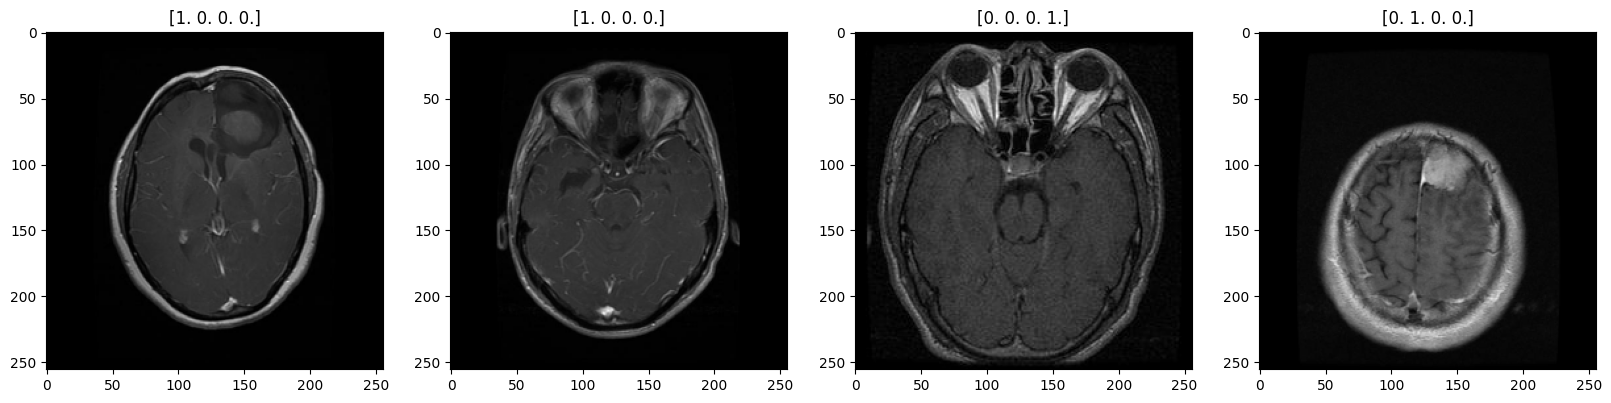

In [8]:
fig,axs = plt.subplots(ncols=4, figsize=(20,20))
for id,img in enumerate(batch[0][:4]):
    axs[id].imshow(img.astype(int))
    axs[id].title.set_text(batch[1][id])

Splitting datasets

In [9]:
print(len(data))

179


In [10]:
print(batch[0].shape)

(32, 256, 256, 3)


In [11]:
train_size = int(len(data)*0.75)
val_size = int(len(data)*0.10)+2
test_size = int(len(data)*0.15)
print(train_size,':',val_size,':',test_size)

134 : 19 : 26


In [12]:
train = data.take(train_size)
validation = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

Model Architecture

In [13]:
model = Sequential()

model.add(Conv2D(filters=32,kernel_size=(3,3),strides=1,activation='relu',input_shape=(256,256,3)))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(filters=64,kernel_size=(3,3),strides=1,activation='relu'))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(filters=128,kernel_size=(3,3),strides=1,activation='relu'))
model.add(MaxPooling2D((2,2)))

model.add(Flatten())
model.add(Dense(units=128,activation='relu'))
model.add(Dense(units=4,activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 128)      0

Model training and evaluation

In [14]:
results = model.fit(train,epochs=15,validation_data=validation)

Epoch 1/15
134/134 [==============================] - 1104s 8s/step - loss: 28.5220 - accuracy: 0.7358 - val_loss: 0.4137 - val_accuracy: 0.8816
Epoch 2/15
134/134 [==============================] - 742s 6s/step - loss: 0.3668 - accuracy: 0.8815 - val_loss: 0.3826 - val_accuracy: 0.9013
Epoch 3/15
134/134 [==============================] - 703s 5s/step - loss: 0.2121 - accuracy: 0.9275 - val_loss: 0.3079 - val_accuracy: 0.9194
Epoch 4/15
134/134 [==============================] - 680s 5s/step - loss: 0.0967 - accuracy: 0.9655 - val_loss: 0.2817 - val_accuracy: 0.9293
Epoch 5/15
134/134 [==============================] - 687s 5s/step - loss: 0.0835 - accuracy: 0.9725 - val_loss: 0.3921 - val_accuracy: 0.9062
Epoch 6/15
134/134 [==============================] - 37544s 282s/step - loss: 0.0937 - accuracy: 0.9690 - val_loss: 0.2676 - val_accuracy: 0.9276
Epoch 7/15
134/134 [==============================] - 849s 6s/step - loss: 0.0553 - accuracy: 0.9827 - val_loss: 0.2594 - val_accuracy: 

Testing model

In [20]:
precision = Precision()
recall = Recall()
accuracy = Accuracy()

In [21]:
for test_batch in test:
    X,y = test_batch
    pred = model.predict(X)
    precision.update_state(y,pred)
    recall.update_state(y,pred)
    accuracy.update_state(y,pred)
    
print('precision:{}\nrecall:{}\naccuracy:{}'.format(precision.result(),recall.result(),accuracy.result()))

1/1 [==============================] - 1s 670ms/step
precision:0.8982843160629272
recall:0.8982843160629272
accuracy:0.11274509876966476


Save model

In [22]:
save_path = r'D:\BrainTumorDetector\model'
model.save(os.path.join(save_path,'ICmodel.h5'))

In [43]:
test_fol = r'D:\BrainTumorDetector\Testing'
test_dirs = ['glioma','meningioma','notumor','pituitary']
directory = random.choice(test_dirs)
allimgs = os.listdir(os.path.join(test_fol,directory))
test_img = random.choice(allimgs)
test_img = os.path.join(test_fol,directory,test_img)
print(test_img)
timg = cv2.imread(test_img)
timg = tf.image.resize(timg,(256,256))
print(timg.shape)

D:\BrainTumorDetector\Testing\pituitary\Te-piTr_0008.jpg
(256, 256, 3)


In [44]:
predict = model.predict(np.expand_dims(timg,axis=0))
print(np.argmax(predict))

1/1 [==============================] - 0s 133ms/step
3
